In [49]:
# read python libraries

import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.style as style
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")


# Load Data

flights.csv is so large, so typical pandas read csv method is slow.
By using map reduce model, a large csv file would be load in multiple chunks for speed and memory purpose

In [50]:
def process_chunk(df):
    df = df.query('DAY == "1"') 
#     print(df.shape)
    return df

In [51]:
chunks = pd.read_csv('input/flight-delays/flights.csv', chunksize=10000)

chunk_list = []                # used for storing dataframes
for chunk in chunks:           # each chunk is a dataframe    
    # perform data filtering 
    filtered_chunk = process_chunk(chunk)
    
    # Once the data filtering is done, append the filtered chunk to list
    chunk_list.append(filtered_chunk)

# concat all the dfs in the list into a single dataframe 
df = pd.concat(chunk_list)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,189477.0,189477.000000,189477.0,189477.000000,189477.000000,189477.000000,184346.000000,184346.000000,184213.000000,184213.000000,189476.000000,183574.000000,183574.000000,189477.000000,184052.000000,184052.000000,189477.000000,184052.000000,183574.000000,189477.000000,189477.000000,36198.000000,36198.000000,36198.000000,36198.000000,36198.000000
mean,2015.0,6.611689,1.0,4.161233,2164.492276,1339.331391,1344.116146,10.538542,16.090021,1366.229555,141.826669,137.306568,113.778051,823.601086,1476.769636,7.461772,1503.599888,1481.054696,5.685146,0.003077,0.028077,14.353196,0.071579,19.297807,23.689624,3.446323
std,0.0,3.378337,0.0,2.035347,1760.465725,480.436936,494.994765,39.142076,9.150913,496.656046,75.355343,74.586258,72.486379,608.651489,523.548429,5.469553,504.831645,528.244486,41.463344,0.055384,0.165194,29.554878,2.069660,47.831899,44.374106,25.980951
min,2015.0,1.000000,1.0,1.000000,1.000000,3.000000,1.000000,-45.000000,1.000000,1.000000,18.000000,14.000000,8.000000,31.000000,1.000000,1.000000,1.000000,1.000000,-68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,4.000000,1.0,2.000000,726.000000,930.000000,930.000000,-5.000000,11.000000,944.000000,85.000000,82.000000,60.000000,373.000000,1101.000000,4.000000,1119.000000,1105.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,7.000000,1.0,4.000000,1672.000000,1332.000000,1338.000000,-1.000000,14.000000,1350.000000,123.000000,119.000000,94.000000,650.000000,1514.000000,6.000000,1528.000000,1518.000000,-5.000000,0.000000,0.000000,2.000000,0.000000,3.000000,3.000000,0.000000
75%,2015.0,10.000000,1.0,6.000000,3206.000000,1735.000000,1744.000000,9.000000,19.000000,1758.000000,174.000000,169.000000,144.000000,1065.000000,1914.000000,9.000000,1921.000000,1918.000000,9.000000,0.000000,0.000000,18.000000,0.000000,19.000000,29.000000,0.000000
max,2015.0,12.000000,1.0,7.000000,9794.000000,2359.000000,2400.000000,1878.000000,180.000000,2400.000000,718.000000,711.000000,669.000000,4983.000000,2400.000000,168.000000,2359.000000,2400.000000,1898.000000,1.000000,1.000000,991.000000,190.000000,1878.000000,864.000000,1118.000000


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189477 entries, 0 to 5355671
Data columns (total 31 columns):
YEAR                   189477 non-null int64
MONTH                  189477 non-null int64
DAY                    189477 non-null int64
DAY_OF_WEEK            189477 non-null int64
AIRLINE                189477 non-null object
FLIGHT_NUMBER          189477 non-null int64
TAIL_NUMBER            188645 non-null object
ORIGIN_AIRPORT         189477 non-null object
DESTINATION_AIRPORT    189477 non-null object
SCHEDULED_DEPARTURE    189477 non-null int64
DEPARTURE_TIME         184346 non-null float64
DEPARTURE_DELAY        184346 non-null float64
TAXI_OUT               184213 non-null float64
WHEELS_OFF             184213 non-null float64
SCHEDULED_TIME         189476 non-null float64
ELAPSED_TIME           183574 non-null float64
AIR_TIME               183574 non-null float64
DISTANCE               189477 non-null int64
WHEELS_ON              184052 non-null float64
TAXI_IN      

## Data Cleaning

### 1. Dates and times

In the initial dataframe, dates are coded according to 4 variables: `YEAR`, `MONTH`, `DAY`, and `DAY_OF_WEEK`. In fact, python offers the `datetime` format which is really convenient to work with dates and times and I thus convert the dates in this format:


In [54]:
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df['DATE'].describe()

count                  189477
unique                     12
top       2015-06-01 00:00:00
freq                    17002
first     2015-01-01 00:00:00
last      2015-12-01 00:00:00
Name: DATE, dtype: object

Moreover, in the `SCHEDULED_DEPARTURE` variable, the hour of the take-off is coded as a float where the two first digits indicate the hour and the two last, the minutes. This format is not convenient and I thus convert it. Finally, I merge the take-off hour with the flight date. To proceed with these transformations, I define a few functions:

In [55]:
# Function that convert the 'HHMM' string to datetime.time
def format_hour(chain):
    if pd.isnull(chain):
        return np.nan
    else:
        if chain == 2400: chain = 0
        chain = "{0:04d}".format(int(chain))
        hour = datetime.time(int(chain[0:2]), int(chain[2:4]))
        return hour

# Function that combines a date and time to produce a datetime.datetime
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])

# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            liste.append(combine_date_hour(cols))
    return pd.Series(liste)

In [56]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_hour)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_hour)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_hour)
#__________________________________________________________________________
df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


Note that in practice, the content of the `DEPARTURE_TIME` and `ARRIVAL_TIME` variables can be a bit misleading since they don't contain the dates. For exemple, in the first entry of the dataframe, the scheduled departure is at 0h05 the 1st of January. The `DEPARTURE_TIME` variable indicates 23h54 and we thus don't know if the flight leaved before time or if there was a large delay. Hence, the `DEPARTURE_DELAY` and `ARRIVAL_DELAY` variables proves more useful since they directly provides the delays in minutes. Hence, in what follows, I will not use the `DEPARTURE_TIME` and `ARRIVAL_TIME` variables.

### 2. Filling factor
Finally, I clean the dataframe throwing the variables I won't use and re-organize the columns to ease its reading:

In [57]:
# variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
#                        'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
#                        'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
#                        'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
#                        'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
# df.drop(variables_to_remove, axis = 1, inplace = True)
# df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
#         'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
#         'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
#         'SCHEDULED_TIME', 'ELAPSED_TIME']]
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,04:30:00,04:08:00,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,07:50:00,07:41:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
2,2015,1,1,4,US,840,N171US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,08:06:00,08:11:00,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,08:05:00,07:56:00,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,03:20:00,02:59:00,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01


At this stage, I examine how complete the dataset is:

In [58]:
pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], 
              axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

,Missing Records,Percentage (%)
YEAR,0,0.000000
MONTH,0,0.000000
DAY,0,0.000000
DAY_OF_WEEK,0,0.000000
AIRLINE,0,0.000000
FLIGHT_NUMBER,0,0.000000
TAIL_NUMBER,832,0.439103
ORIGIN_AIRPORT,0,0.000000
DESTINATION_AIRPORT,0,0.000000
SCHEDULED_DEPARTURE,175527,92.637629


We see that the variables filling factor is quite good (> 97%). Since the scope of this work is not to idenfity delays pattern for possible improvement, I decide to proceed without trying to impute what's missing and I simply remove the entries that contain missing values.

In [59]:
# df.dropna(inplace = True)

## Comparing airlines

As said earlier, the `AIRLINE` variable contains the airline abreviations. Their full names can be retrieved from the airlines.csv file.

In [60]:
airlines_names = pd.read_csv('input/flight-delays/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [61]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [68]:
airports= pd.read_csv('input/flight-delays/airports.csv')
identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()

### 2.1 Basic statistical description of airlines

As a first step, I consider all the flights from all carriers. Here, the aim is to classify the airlines with respect to their punctuality and for that purpose, I compute a few basic statisticial parameters:

In [69]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)
# abbr_companies = airlines.set_index('IATA_CODE')['AIRLINE'].to_dict()
# identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()

# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#___________________________________________________________

for carrier in abbr_companies.keys():
    fg1 = df[df['AIRLINE'] == carrier]
    test = fg1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

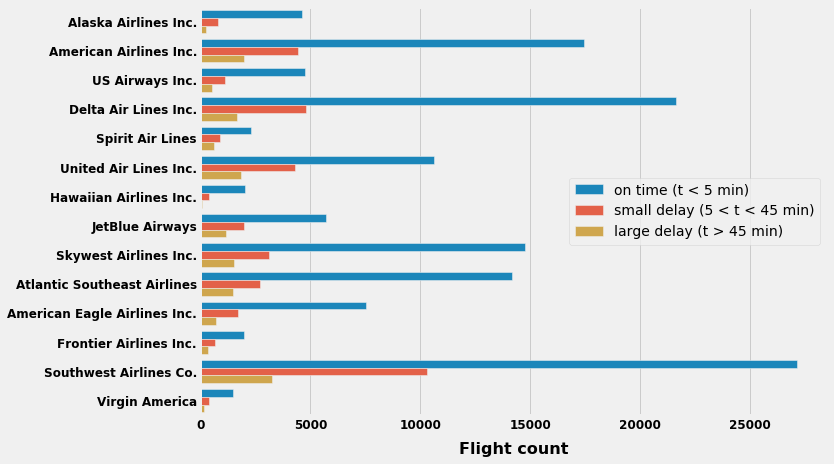

In [66]:
style.use('fivethirtyeight')
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'bold', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

This figure gives a count of the delays of less than 5 minutes, those in the range 5 < t < 45 min and finally, the delays greater than 45 minutes. Hence, we wee that independently of the airline, delays greater than 45 minutes only account for a few percents. However, the proportion of delays in these three groups depends on the airline: as an exemple, in the case of United Airlines, the delays greater than 45 minutes are 2 times less frequent than delays in the range 5 < t < 45 min. Things are better for Southwest Airlines since delays greater than 45 minutes are 3 times less frequent than delays in the range 5 < t < 45 min.

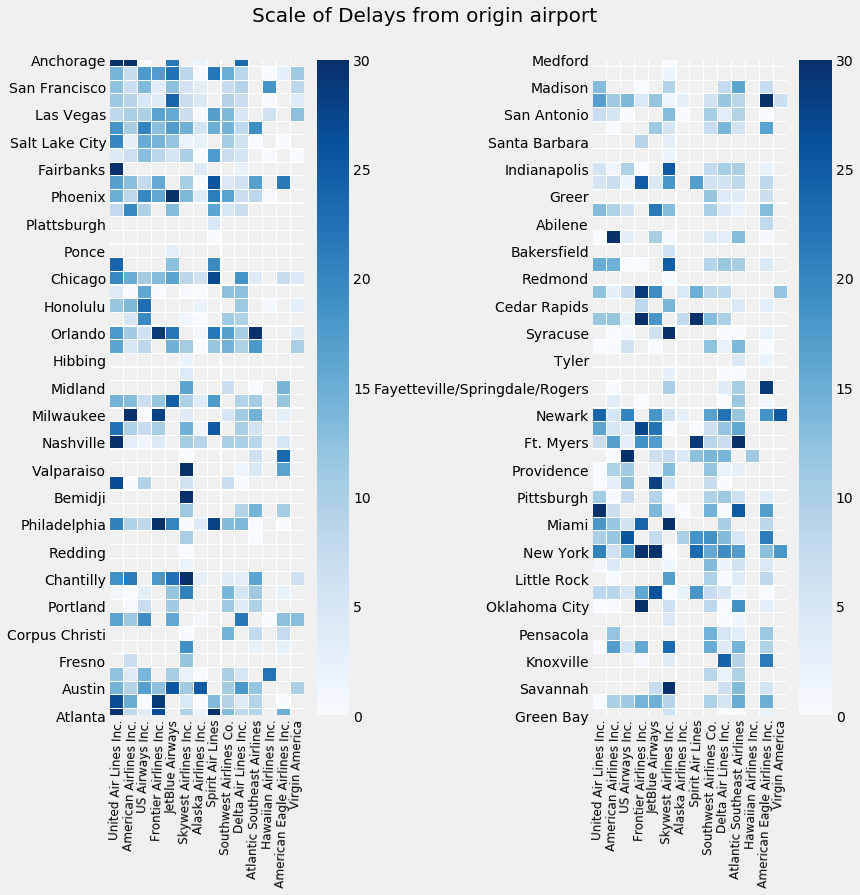

In [71]:
fig = plt.figure(1, figsize=(12,12))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="Blues", mask=mask, vmin = 0, vmax = 30)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 88) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = abbr_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Scale of Delays from origin airport", ha='center', fontsize = 20)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.05, cmap="Blues", mask=mask, vmin = 0, vmax = 30)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 88) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

Looks like the airlines with most number of flights in 2015 are Southwest (1.2M flights - ranked No.1), Delta, American and Skywest, which also have relatively low cancellation rate. American Eagle has the highest cancellation rate - around 5%.

Also, the divertation rate seems positively correlated with the flight volume. Overall the divertion rate is less than 1%.